In [13]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from scipy.optimize import curve_fit, minimize_scalar 
from scipy.stats import norm, multivariate_normal
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')

Missing colon in file '/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle', line 108 ('                             s, palatino,')
Bad value in file '/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle', line 159 ("mathtext.fontset : Times New Roman  # Should be 'cm' (Computer Modern), 'stix',"): Key mathtext.fontset: 'Times New Roman' is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
Bad value in file '/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle', line 161 ("mathtext.fallback: Times New Roman  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: times new roman is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [14]:
def LoadData(energy):
    #filename = f'/home/llr/ilc/ritzmann/work/ana_files_ECAL_QGSP_BERT_conf6_e-__GeV_5kevt_build_masked/data_nhits_wenergy_{energy}GeV.txt'
    filename = f'/home/llr/ilc/ritzmann/work/ECAL_QGSP_BERT_conf6_e-_GeV_5kevt_-42_-42_build_masked_data_shower_{energy}GeV.txt'
    df = pd.read_csv(filename, header=0)
    return df

In [15]:
#two ways to calculate the weighted energy sum

#used for wenergy1
def sampling_fraction1(layer):
    X0W = 3.504
    X0Si = 93.70*1000 #microns!
    Ecal_WThickness = 0.7/X0W
    d_SiX0 = np.array([650.0/X0Si, 650.0/X0Si, 650.0/X0Si, 650.0/X0Si,500.0/X0Si, 500.0/X0Si, 500.0/X0Si, 500.0/X0Si, 500.0/X0Si, 500.0/X0Si,320.0/X0Si, 320.0/X0Si, 320.0/X0Si, 320.0/X0Si, 320.0/X0Si])
    d_WX0 = np.array([6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness])

    f0 = (d_SiX0[layer])/(d_SiX0[layer] + d_WX0[layer])
    
    return 1 / f0


#used for wenergy2
def sampling_fraction2(layer):
    X0W = 3.504
    X0Si = 93.70*1000 #microns!
    Ecal_WThickness = 0.7/X0W
    d_SiX0 = np.array([650.0/X0Si, 650.0/X0Si, 650.0/X0Si, 650.0/X0Si,500.0/X0Si, 500.0/X0Si, 500.0/X0Si, 500.0/X0Si, 500.0/X0Si, 500.0/X0Si,320.0/X0Si, 320.0/X0Si, 320.0/X0Si, 320.0/X0Si, 320.0/X0Si])
    d_WX0 = np.array([6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,6*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness,8*Ecal_WThickness])

    f0 = 1/(d_SiX0[layer] + d_WX0[layer])
    
    return 1 / f0

In [16]:
energies = ["0.25", "0.5", "0.7", "1", "2", "5", "8", "10", "20", "40", "60", "80", "100", "150", "200", "250"]
dfs = [LoadData(e) for e in energies]

In [17]:
#nonwenergy is the unweighted energy sum 
df = dfs[5]
df.head()

,nhits,wnhits,wenergy1,wenergy2,nonwenergy
0,99,131.975,72710.4,362.280,278
1,93,119.992,68473.4,382.529,306
2,95,119.595,63568.5,359.681,291
3,107,136.833,80955.6,445.546,359
4,89,120.728,72375.5,380.352,293


Text(0.5, 0.98, 'Weighted sum energy (2) vs. number of hits')

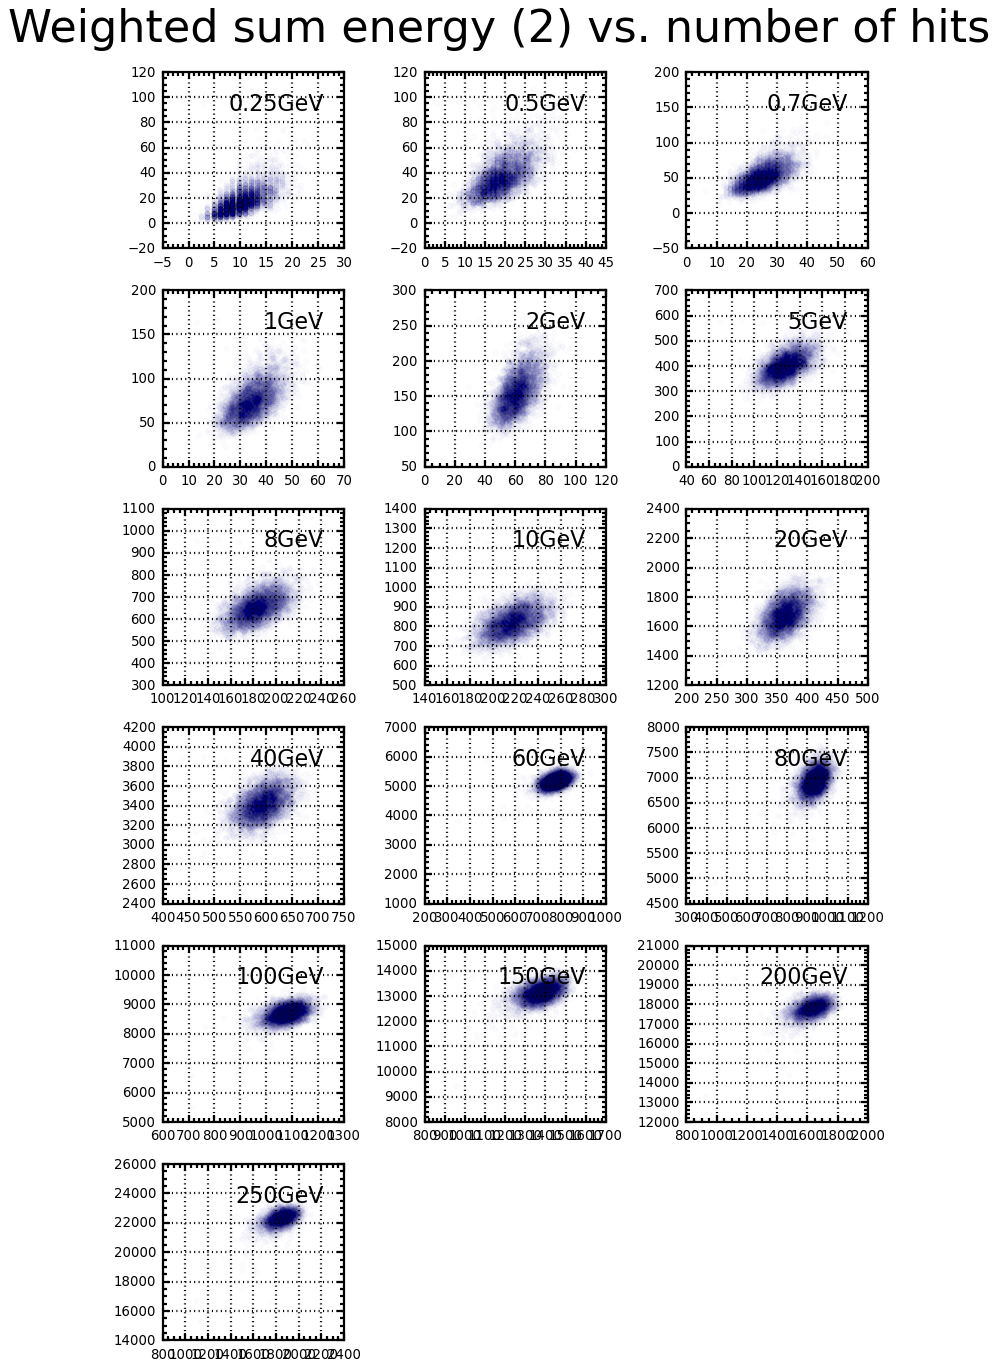

In [ ]:
# quick check -> all the scatter plots individually
ncols = 3
nrows = int(len(energies)/ncols + 1)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 3*nrows))
for ie, e in enumerate(energies):
    df = dfs[ie]
    ax = axs.flat[ie]
    ax.scatter(df['wnhits'], df['wenergy2'], alpha=0.01, label = f'{e}GeV')
    ax.legend()
    ax.tick_params(axis='x', labelsize=12)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.tick_params(axis='y', labelsize=12)
diff = nrows*ncols-len(energies)
if diff > 0:
    for i in range(diff):
        fig.delaxes(axs.flat[-(i+1)])


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted sum energy (2) vs. number of hits")

In [19]:
#function calculating the fitting parameters for the bivariate distribution
def fit_bigaus(df, key1, key2):
    mean = np.mean(df[[key1,key2]].to_numpy(), axis=0)
    cov = np.cov(df[[key1, key2]].to_numpy(), rowvar=0)
    #print(mean, cov, 'sigma1=',np.sqrt(cov[0][0]), 'sigma2=',np.sqrt(cov[1][1]),'rho=', cov[1][0]/(np.sqrt(cov[0][0])*np.sqrt(cov[1][1])))
    var = multivariate_normal(mean=mean, cov=cov)
    return var

In [20]:
#choose two parameters and fit the bivariate distribution

bigaus_array_nhits_wenergy1 = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_nhits_wenergy1.append(fit_bigaus(df, 'nhits', 'wenergy1'))
    
bigaus_array_nhits_wenergy2 = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_nhits_wenergy2.append(fit_bigaus(df, 'nhits', 'wenergy2'))
    
bigaus_array_nhits_nonwenergy = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_nhits_nonwenergy.append(fit_bigaus(df, 'nhits', 'nonwenergy'))
    
bigaus_array_wnhits_wenergy1 = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_wnhits_wenergy1.append(fit_bigaus(df, 'wnhits', 'wenergy1'))
    
bigaus_array_wnhits_wenergy2 = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_wnhits_wenergy2.append(fit_bigaus(df, 'wnhits', 'wenergy2'))
    
bigaus_array_wnhits_nonwenergy = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_wnhits_nonwenergy.append(fit_bigaus(df, 'wnhits', 'nonwenergy'))
    
bigaus_array_wenergy1_nonwenergy = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_wenergy1_nonwenergy.append(fit_bigaus(df, 'wenergy1', 'nonwenergy'))
    
bigaus_array_wenergy2_nonwenergy = []
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus_array_wenergy2_nonwenergy.append(fit_bigaus(df, 'wenergy2', 'nonwenergy'))

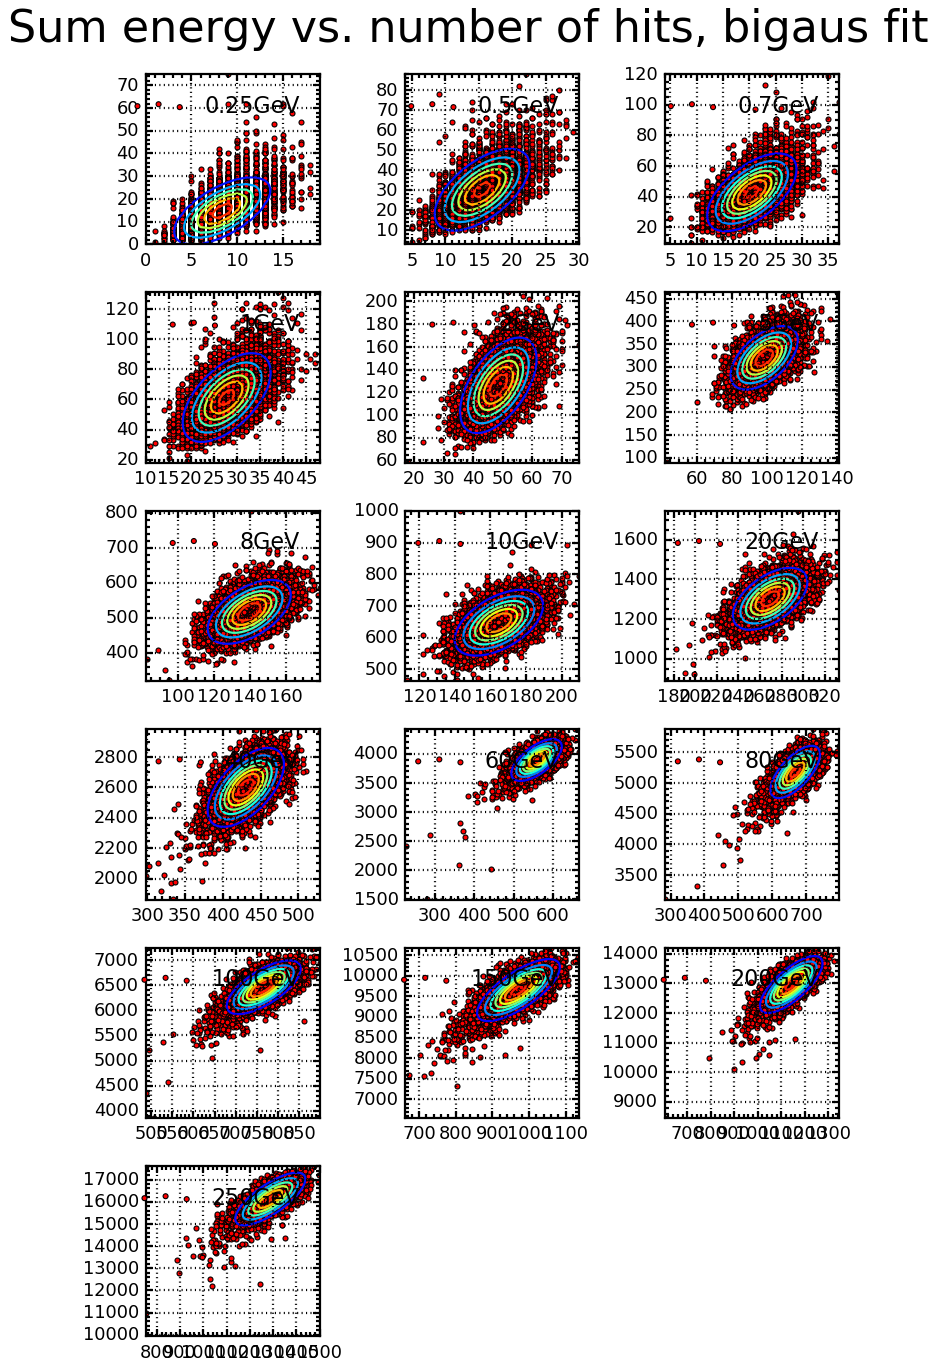

In [21]:
# now plot with 2d fit
ncols = 3
nrows = int(len(energies)/ncols + 1)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 3*nrows))
for ie, e in enumerate(energies):
    df = dfs[ie]
    bigaus = bigaus_array_nhits_nonwenergy[ie]
    xmin=int(df['nhits'].min())-1
    xmax=int(df['nhits'].max())+1
    ymin=int(df['nonwenergy'].min())-1
    ymax=int(df['nonwenergy'].max())+1
    x, y = np.mgrid[xmin:xmax:1, ymin:ymax:1]
    pos=np.dstack((x, y))
    
    ax = axs.flat[ie]
    ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['nhits'], df['nonwenergy'], label = f'{e}GeV', c='red')
    # ax.set_xlabel('nhit_len')
    # ax.set_ylabel('sum_energy')
    ax.legend()
    # plt.colorbar()

    # ax.scatter(df['nhit_len'], df['sum_energy'], alpha=0.01, label = f'{e}GeV')
    # ax.legend()
diff = nrows*ncols-len(energies)
if diff > 0:
    for i in range(diff):
        fig.delaxes(axs.flat[-(i+1)])


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Sum energy vs. number of hits, bigaus fit");

0
1
2
3
4
5
6
7
8
9
10


11
12
13
14
15


PermissionError: [Errno 13] Permission denied: '/grid_mnt/vol_home/llr/ilc/ritzmann/work/megaplot_distributions_wnhits_wenergy2.png'

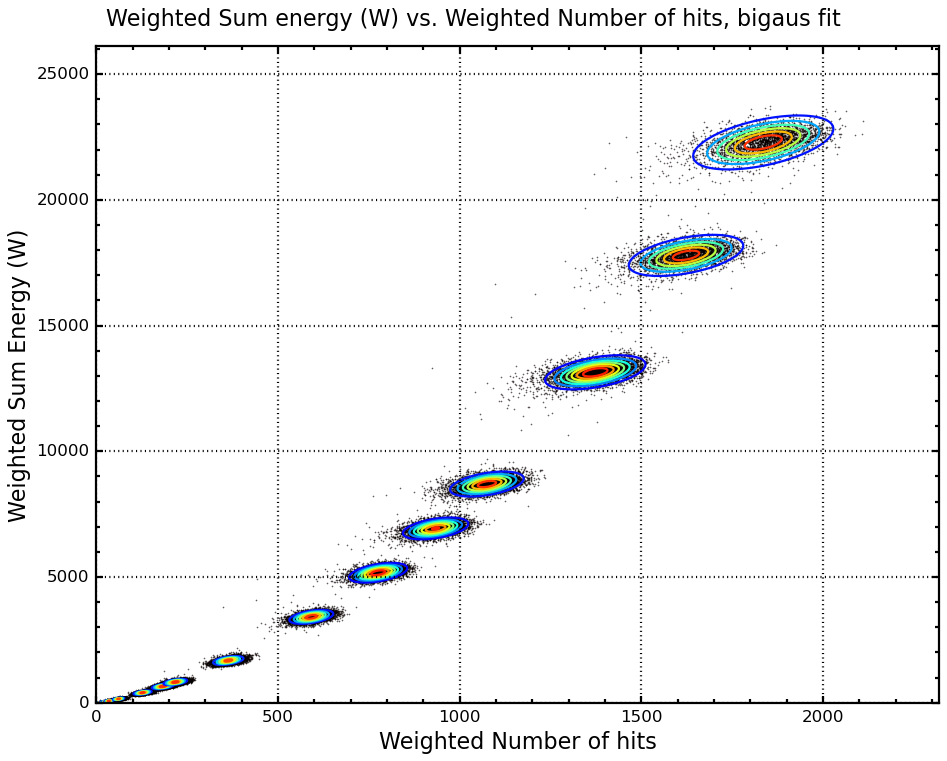

In [22]:
# megaplot with all resolutions
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies):

    df = dfs[ie]
    print(ie)
    bigaus = bigaus_array_wnhits_wenergy2[ie]
    xmin=int(df['wnhits'].min())-1
    xmax=int(df['wnhits'].max())+1
    ymin=int(df['wenergy2'].min())-1
    ymax=int(df['wenergy2'].max())+1
    x, y = np.mgrid[xmin:xmax:1, ymin:ymax:1]
    pos=np.dstack((x, y))
    
    # ax = axs.flat[ie]
    ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['wnhits'], df['wenergy2'], label = f'{e}GeV', c='red', s=0.1)
    # ax.scatter
ax.set_xlabel("Weighted Number of hits", fontsize=20)
ax.set_ylabel("Weighted Sum Energy (W)", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.colorbar()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted Sum energy (W) vs. Weighted Number of hits, bigaus fit", fontsize=20)
fig.savefig('/home/llr/ilc/ritzmann/work/megaplot_distributions_wnhits_wenergy2.png');

In [ ]:
# megaplot with all resolutions
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies):

    df = dfs[ie]
    bigaus = bigaus_array_nhits_wenergy2[ie]
    xmin=int(df['nhits'].min())-1
    xmax=int(df['nhits'].max())+1
    ymin=int(df['wenergy2'].min())-1
    ymax=int(df['wenergy2'].max())+1
    x, y = np.mgrid[xmin:xmax:1, ymin:ymax:1]
    pos=np.dstack((x, y))
    
    # ax = axs.flat[ie]
    ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['nhits'], df['wenergy2'], label = f'{e}GeV', c='red', s=0.1)
    # ax.scatter
ax.set_xlabel("Number of hits", fontsize=20)
ax.set_ylabel("Weighted Sum energy (2)", fontsize=20)
# plt.colorbar()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted Sum energy (W) vs. number of hits, bigaus fit", fontsize=20)
#fig.savefig('/home/llr/ilc/ritzmann/work/megaplot_distributions.png');

NameError: name 'plt' is not defined

Text(0.5, 0.98, 'Non-weighted sum energy vs. number of hits, bigaus fit')

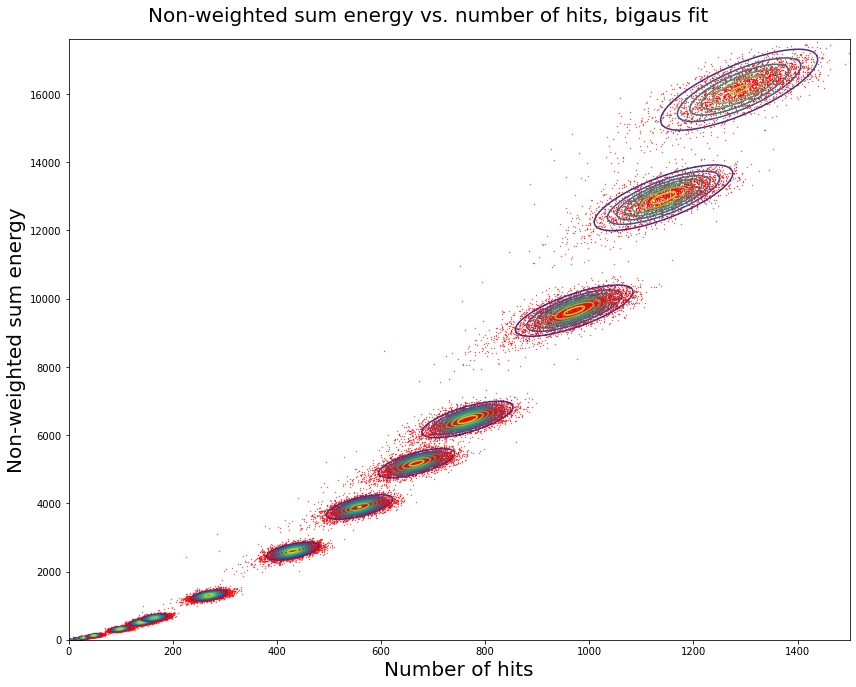

In [ ]:
# megaplot with all resolutions
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies):

    df = dfs[ie]
    bigaus = bigaus_array_nhits_nonwenergy[ie]
    xmin=int(df['nhits'].min())-1
    xmax=int(df['nhits'].max())+1
    ymin=int(df['nonwenergy'].min())-1
    ymax=int(df['nonwenergy'].max())+1
    x, y = np.mgrid[xmin:xmax:1, ymin:ymax:1]
    pos=np.dstack((x, y))
    
    # ax = axs.flat[ie]
    ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['nhits'], df['nonwenergy'], label = f'{e}GeV', c='red', s=0.1)
    # ax.scatter
ax.set_xlabel("Number of hits", fontsize=20)
ax.set_ylabel("Non-weighted sum energy", fontsize=20)
# plt.colorbar()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Non-weighted sum energy vs. number of hits, bigaus fit", fontsize=20)
#fig.savefig('/home/llr/ilc/ritzmann/work/megaplot_distributions.png');

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies):

    df = dfs[ie]
    bigaus = bigaus_array_wenergy1_nonwenergy[ie]
    #xmin=int(df['wenergy1'].min())-1
    #xmax=int(df['wenergy1'].max())+1
    #ymin=int(df['nonwenergy'].min())-1
    #ymax=int(df['nonwenergy'].max())+1
    #x, y = np.mgrid[-3*sigma_1:3*sigma_1, -3*sigma_2:3*sigma_2:1]
    #pos=np.dstack((x, y))
    
    
    # ax = axs.flat[ie]
    #ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['wenergy1'], df['nonwenergy'], label = f'{e}GeV', s=0.1)
    # ax.scatter
ax.set_xlabel("Weighted Sum energy (W + Si)", fontsize=20)
ax.set_ylabel("Non-weighted Sum energy", fontsize=20)
ax.legend(markerscale=20, fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted Sum energy (W + Si) vs. non-weighted sum energy, bigaus fit", fontsize=20)

NameError: name 'plt' is not defined

Text(0.5, 0.98, 'Weighted Sum energy (1) vs. non-weighted sum energy, bigaus fit')

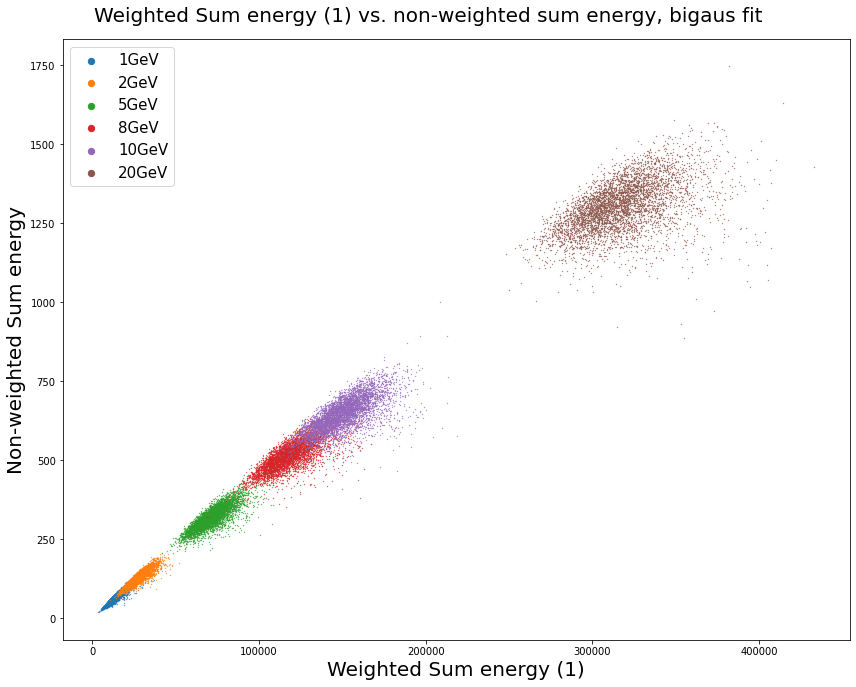

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies[:6]):

    df = dfs[ie]
    bigaus = bigaus_array_wenergy1_nonwenergy[ie]
    #xmin=int(df['wenergy1'].min())-1
    #xmax=int(df['wenergy1'].max())+1
    #ymin=int(df['nonwenergy'].min())-1
    #ymax=int(df['nonwenergy'].max())+1
    #x, y = np.mgrid[-3*sigma_1:3*sigma_1, -3*sigma_2:3*sigma_2:1]
    #pos=np.dstack((x, y))
    
    
    # ax = axs.flat[ie]
    #ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['wenergy1'], df['nonwenergy'], label = f'{e}GeV', s=0.1)
    # ax.scatter
ax.set_xlabel("Weighted Sum energy (W + Si)", fontsize=20)
ax.set_ylabel("Non-weighted Sum energy", fontsize=20)
ax.legend(markerscale=20, fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted Sum energy (W + Si) vs. non-weighted sum energy, bigaus fit", fontsize=20)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies):

    df = dfs[ie]
    bigaus = bigaus_array_wenergy2_nonwenergy[ie]
    #xmin=int(df['wenergy1'].min())-1
    #xmax=int(df['wenergy1'].max())+1
    #ymin=int(df['nonwenergy'].min())-1
    #ymax=int(df['nonwenergy'].max())+1
    #x, y = np.mgrid[-3*sigma_1:3*sigma_1, -3*sigma_2:3*sigma_2:1]
    #pos=np.dstack((x, y))
    
    
    # ax = axs.flat[ie]
    #ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['wenergy2'], df['nonwenergy'], label = f'{e}GeV', s=0.1)
    # ax.scatter
ax.set_xlabel("Weighted Sum energy (W)", fontsize=20)
ax.set_ylabel("Non-weighted Sum energy", fontsize=20)
ax.legend(markerscale=20, fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted Sum energy (W) vs. non-weighted sum energy, bigaus fit", fontsize=20)

NameError: name 'plt' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
for ie, e in enumerate(energies[:6]):

    df = dfs[ie]
    bigaus = bigaus_array_wenergy2_nonwenergy[ie]
    #xmin=int(df['wenergy1'].min())-1
    #xmax=int(df['wenergy1'].max())+1
    #ymin=int(df['nonwenergy'].min())-1
    #ymax=int(df['nonwenergy'].max())+1
    #x, y = np.mgrid[-3*sigma_1:3*sigma_1, -3*sigma_2:3*sigma_2:1]
    #pos=np.dstack((x, y))
    
    
    # ax = axs.flat[ie]
    #ax.contour(x, y, bigaus.pdf(pos))
    ax.scatter(df['wenergy2'], df['nonwenergy'], label = f'{e}GeV', s=0.1)
    # ax.scatter
ax.set_xlabel("Weighted Sum energy (W)", fontsize=20)
ax.set_ylabel("Non-weighted Sum energy", fontsize=20)
ax.legend(markerscale=20, fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Weighted Sum energy (W) vs. non-weighted sum energy, bigaus fit", fontsize=20)

NameError: name 'plt' is not defined